In [1]:
# Load Libraries
import pandas as pd
import pickle
from pandas import DataFrame, Series
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model, naive_bayes
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
import pybaseball as pyb
from pybaseball import statcast
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [2]:
# Import Data
df = pd.read_csv("/Users/genoc/Desktop/HyannisHarborHawks/Trackman/Cape_Trackman_Combined_July7.csv",low_memory=False)

# Clean Trackman Data
dft = df[['Pitcher', 'PitcherTeam', 'Batter', 'BatterTeam', 'PitcherThrows', 'RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak', 'PitchCall', 'PlayResult', 'TaggedHitType', 'KorBB']]

#Rename the columns to be more descriptive
dft.rename(columns={'BatterTeam':'Batter Team', 'PitcherTeam':'Pitcher Team', 'PitcherThrows':'P Side', 'RelSpeed':'Velocity', 'SpinRate':'Spin Rate', 'RelHeight':'Release Height', 'RelSide':'Release Side', 'Extension':'Extension', 'InducedVertBreak':'Induced Vertical Break', 'HorzBreak':'Horizontal Break', 'PitchCall':'Pitch Call', 'PlayResult':'Play Result', 'TaggedHitType':'Hit Type'}, inplace=True)

#Add the Pitch Type and Pitch Result to the new dataframe
dft.insert(1, 'Pitch Type', df['TaggedPitchType'])
dft.insert(2, 'Pitch Result', df['PitchCall'])

#Create a new column for the difference between the Induced Vertical Break and the Horizontal Break (Absolute Value)
dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()

#Add two new columns for Pitch Location
dft.insert(10, 'Pitch Height', df['PlateLocHeight'])
dft.insert(11, 'Pitch Side', df['PlateLocSide'])

#Edit Horizontal Break to be absolute value of horizontal break
dft['Horizontal Break'] = abs(dft['Horizontal Break'])

dft['Release Side'] = abs(dft['Release Side'])

# Edit the pitcher names so the first name is first and the last name is last
dft['Pitcher'] = dft['Pitcher'].str.split(' ', expand=True)[1] + ' ' + dft['Pitcher'].str.split(' ', expand=True)[0]

# Edit the batter names so the first name is first and the last name is last
dft['Batter'] = dft['Batter'].str.split(' ', expand=True)[1] + ' ' + dft['Batter'].str.split(' ', expand=True)[0]

# Remove the comma from the last name
dft = dft.replace(',', '', regex=True)

# Add Swings and Misses to dft
dft['Whiff'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" else 0)
dft['Swing'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" or x == "InPlay" else 0)

# Calculates total swings and total misses across all of dft
total_swings = dft['Swing'].sum()
total_misses = dft['Whiff'].sum()

# Calculates Whiff Rate for all of dft
league_average_whiff_rate = total_misses / total_swings

# Create a new dataframe with only pitches that are Four-Seam FB from RHP
dfbr = dft[(dft['Pitch Type'] == 'Fastball')]

# Handle NA values
dfbr.fillna(dfbr.mean(), inplace=True)

dfbr['Hgt x IVB'] = dfbr['Release Height'] * dfbr['Induced Vertical Break']
dfbr['Velo^3 + Velo^2'] = pow(dfbr['Velocity'], 3) + pow(dfbr['Velocity'], 2)

#dfbr[['Velocity', 'Spin Rate', 'Release Height', 'Release Side', 'Extension', 'Horizontal Break', 'Differential Break', 'Induced Vertical Break']].corr()

dfbr['Velo^2'] = pow(dfbr['Velocity'], 2)
dfbr['Velo^3'] = pow(dfbr['Velocity'], 3)
dfbr['IndVert^2'] = pow(dfbr['Induced Vertical Break'], 2)
dfbr['DiffBreak^2'] = pow(dfbr['Differential Break'], 2)

# Filter to only include swings
dfbr_swing = dfbr[(dfbr['Swing'] == 1)]

C:\Users\genoc\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-2-625e8c9ba482>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()
<ipython-input-2-625e8c9ba482>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [3]:
# Linear regression Model

X = dfbr_swing[['Release Side', 'Hgt x IVB', 'Extension', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfbr_swing['Whiff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression object
linear_model = LinearRegression()

# Train the linear regression model using the training data
linear_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the linear regression model
y_linear_pred = linear_model.predict(X_test_scaled)

# Evaluate the linear regression model's performance
linear_mse = mean_squared_error(y_test, y_linear_pred)
linear_r2 = r2_score(y_test, y_linear_pred)

print("Linear Regression Mean Squared Error:", linear_mse)
print("Linear Regression R-squared score:", linear_r2)

Linear Regression Mean Squared Error: 0.2154854382035612
Linear Regression R-squared score: 0.024655067504225525


In [4]:
# Get the feature coefficients from the model
feature_importances = linear_model.coef_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)


                 importance
IndVert^2          0.137193
Velo^3 + Velo^2    0.045819
DiffBreak^2        0.043529
Release Side       0.014639
Extension          0.004585
Hgt x IVB         -0.086833


In [5]:
# Random Forest Model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest regressor object
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model using the training data
random_forest_model.fit(X_train, y_train)

# Predict Stuff+ scores for the test set using the Random Forest model
y_rf_pred = random_forest_model.predict(X_test)

# Evaluate the Random Forest model's performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared score:", rf_r2)

Random Forest Mean Squared Error: 0.23083419894104565
Random Forest R-squared score: -0.04481754340720712


In [6]:
# Get feature importances from the model
feature_importances = random_forest_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

                 importance
IndVert^2          0.180638
Velo^3 + Velo^2    0.171090
DiffBreak^2        0.168583
Release Side       0.167003
Extension          0.164137
Hgt x IVB          0.148550


In [7]:
# XG Boost Model

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the XGBoost regressor object
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the XGBoost model using the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the XGBoost model
y_xgb_pred = xgb_model.predict(X_test_scaled)

# Evaluate the XGBoost model's performance
xgb_mse = mean_squared_error(y_test, y_xgb_pred)
xgb_r2 = r2_score(y_test, y_xgb_pred)

print("XGBoost Mean Squared Error:", xgb_mse)
print("XGBoost R-squared score:", xgb_r2)

XGBoost Mean Squared Error: 0.22912469653221415
XGBoost R-squared score: -0.03707987665142376


In [8]:
# Get feature importances from the model
feature_importances = xgb_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

                 importance
IndVert^2          0.222383
DiffBreak^2        0.178191
Velo^3 + Velo^2    0.170267
Hgt x IVB          0.150580
Extension          0.144744
Release Side       0.133837


In [9]:
# SVR Model 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Support Vector Regression model
svr_model = SVR(kernel='linear')

# Train the model using the training data
svr_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the SVR model
y_pred = svr_model.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)

Mean Squared Error: 0.27358741156928135
R-squared score: -0.23833005929922035


In [10]:
# Neural Networks Model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better neural network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1))  # Single output neuron for the Stuff+ score prediction

# Compile the model
nn_model.compile(optimizer='adam', loss='mse')

# Train the model using the training data
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Predict Stuff+ scores for the test set using the Neural Network model
y_pred = nn_model.predict(X_test_scaled).flatten()

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)

20/20 [==============================] - 0s 2ms/step
Mean Squared Error: 0.2394875183811084
R-squared score: -0.08398478986011804


In [11]:
# Ensemble model

# Make predictions using all the models
linear_pred = linear_model.predict(X_test_scaled)
rf_pred = random_forest_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
svr_pred = svr_model.predict(X_test_scaled)
keras_nn_pred = nn_model.predict(X_test_scaled).flatten()

# Combine predictions using averaging
ensemble_predictions = (linear_pred + rf_pred + xgb_pred + svr_pred + keras_nn_pred) / 5.0

20/20 [==============================] - 0s 2ms/step


In [12]:
# Get feature importances from the RandomForestRegressor and XGBRegressor models
rf_feature_importances = random_forest_model.feature_importances_
xgb_feature_importances = xgb_model.feature_importances_

# Calculate average feature importances across the two models
average_feature_importances = (rf_feature_importances + xgb_feature_importances) / 2.0

[0.16700261 0.14854998 0.1641369  0.17109023 0.18063767 0.1685826 ]
[0.13383667 0.15057951 0.14474355 0.17026685 0.2223825  0.17819087]
[0.15041964 0.14956475 0.15444022 0.17067854 0.20151009 0.17338674]


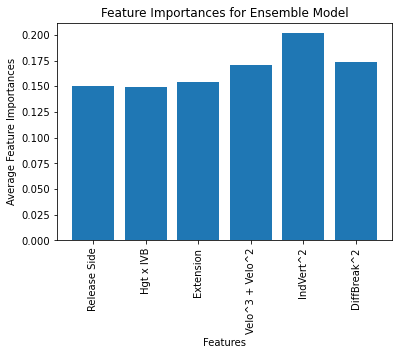

In [13]:
features_list = ['Release Side', 'Hgt x IVB', 'Extension', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']

plt.bar(features_list, average_feature_importances)
plt.xlabel('Features')
plt.ylabel('Average Feature Importances')
plt.title('Feature Importances for Ensemble Model')
plt.xticks(rotation=90)
plt.show()

In [16]:
X = dfbr[['Release Side', 'Hgt x IVB', 'Extension', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfbr['Whiff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Make predictions on the training set using all the models
linear_pred_train = linear_model.predict(X_train_scaled)
rf_pred_train = random_forest_model.predict(X_train_scaled)
xgb_pred_train = xgb_model.predict(X_train_scaled)
svr_pred_train = svr_model.predict(X_train_scaled)
keras_nn_pred_train = nn_model.predict(X_train_scaled).flatten()

In [20]:
# Make predictions on the test set using all the models
linear_pred_test = linear_model.predict(X_test_scaled)
rf_pred_test = random_forest_model.predict(X_test_scaled)
xgb_pred_test = xgb_model.predict(X_test_scaled)
svr_pred_test = svr_model.predict(X_test_scaled)
keras_nn_pred_test = nn_model.predict(X_test_scaled).flatten()

70/70 [==============================] - 0s 2ms/step


In [21]:
# Combine predictions using averaging for the training set
ensemble_predictions_train = (linear_pred_train + rf_pred_train + xgb_pred_train + svr_pred_train + keras_nn_pred_train) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the training set
ensemble_df_train = pd.DataFrame({'expected_whiff_rates': ensemble_predictions_train}, index=X_train.index)

In [22]:
# Combine predictions using averaging for the test set
ensemble_predictions_test = (linear_pred_test + rf_pred_test + xgb_pred_test + svr_pred_test + keras_nn_pred_test) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the test set
ensemble_df_test = pd.DataFrame({'expected_whiff_rates': ensemble_predictions_test}, index=X_test.index)

In [23]:
# Concatenate the training and test set DataFrames
ensemble_df = pd.concat([ensemble_df_train, ensemble_df_test])

In [24]:
# Calculate the 'Stuff+' values
dfbr['Stuff+'] = (ensemble_df['expected_whiff_rates'] / ensemble_df['expected_whiff_rates'].mean()) * 100

<ipython-input-24-b5695bafb0d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfbr['Stuff+'] = (ensemble_df['expected_whiff_rates'] / ensemble_df['expected_whiff_rates'].mean()) * 100


In [33]:
dfbr['Stuff+'].describe()

count    11092.000000
mean       100.000000
std         28.307104
min        -11.700118
25%         80.127791
50%         96.581772
75%        117.431904
max        215.087551
Name: Stuff+, dtype: float64

In [31]:
dfbr.head(30)

,Pitcher,Pitch Type,Pitch Result,Pitcher Team,Batter,Batter Team,P Side,Velocity,Spin Rate,Release Height,...,Differential Break,Whiff,Swing,Hgt x IVB,Velo^3 + Velo^2,Velo^2,Velo^3,IndVert^2,DiffBreak^2,Stuff+
0,Javyn Pimental,Fastball,StrikeCalled,BRE_WHI,Andrew Patrick,BOU_BRA,Left,87.98933,1957.033925,5.28042,...,21.54702,0,0,32.673338,688966.266809,7742.122194,681224.144615,38.286889,464.274071,99.190454
1,Javyn Pimental,Fastball,FoulBall,BRE_WHI,Andrew Patrick,BOU_BRA,Left,87.70173,1975.103291,5.38025,...,23.63478,0,0,36.954301,682257.645028,7691.593445,674566.051583,47.176430,558.602826,125.981628
2,Javyn Pimental,Fastball,BallCalled,BRE_WHI,Andrew Patrick,BOU_BRA,Left,88.60725,1884.329797,5.41630,...,25.65120,0,0,34.676290,703528.451354,7851.244753,695677.206601,40.988293,657.984061,120.249724
3,Javyn Pimental,Fastball,FoulBall,BRE_WHI,Andrew Patrick,BOU_BRA,Left,89.19638,1913.273355,5.30391,...,21.23859,0,0,27.541295,717601.876601,7955.994205,709645.882396,26.963510,451.077705,112.899431
7,Javyn Pimental,Fastball,InPlay,BRE_WHI,Josh Kuroda-Grauer,BOU_BRA,Left,88.58948,2008.972687,5.33875,...,20.51001,0,1,24.391147,703106.836644,7848.095967,695258.740677,20.873020,420.660510,109.710023
8,Javyn Pimental,Fastball,BallCalled,BRE_WHI,Garett Michel,BOU_BRA,Left,88.72472,1989.100067,5.36484,...,22.90533,0,0,28.401356,706319.809453,7872.075939,698447.733513,28.026224,524.654142,129.297014
9,Javyn Pimental,Fastball,BallCalled,BRE_WHI,Garett Michel,BOU_BRA,Left,89.37303,1999.062133,5.28305,...,22.34478,0,0,32.390961,721858.055708,7987.538491,713870.517216,37.590510,499.289193,119.734940
10,Javyn Pimental,Fastball,StrikeCalled,BRE_WHI,Garett Michel,BOU_BRA,Left,88.74737,1994.799075,5.28583,...,23.85037,0,0,37.610795,706858.873320,7876.095682,698982.777638,50.628917,568.840149,119.136791
11,Javyn Pimental,Fastball,StrikeCalled,BRE_WHI,Garett Michel,BOU_BRA,Left,89.02105,1962.352998,5.31561,...,22.87430,0,0,31.685235,713394.076811,7924.747343,705469.329468,35.531017,523.233600,120.979549
13,Javyn Pimental,Fastball,BallCalled,BRE_WHI,Joey Loynd,BOU_BRA,Left,88.67494,1919.422555,5.40716,...,20.80993,0,0,27.669357,705136.022146,7863.244984,697272.777162,26.185429,433.053187,125.165303


In [41]:
# Sort the DataFrame by 'Stuff+' values in descending order
dfbr_sorted = dfbr.sort_values(by='Stuff+', ascending=False)

# Reset the index of the sorted DataFrame
dfbr_sorted.reset_index(drop=True, inplace=True)

dfbr_sorted.head(20)

,Pitcher,Pitch Type,Pitch Result,Pitcher Team,Batter,Batter Team,P Side,Velocity,Spin Rate,Release Height,...,Differential Break,Whiff,Swing,Hgt x IVB,Velo^3 + Velo^2,Velo^2,Velo^3,IndVert^2,DiffBreak^2,Stuff+
0,Andrew Sentlinger,Fastball,BallCalled,BRE_WHI,Logan Sauve,CHA_ANG,Left,90.90232,2268.227683,5.66431,...,34.89128,0,0,155.967286,759410.171407,8263.231781,751146.939625,758.181181,1217.401420,215.087551
1,Andrew Sentlinger,Fastball,StrikeSwinging,BRE_WHI,Logan Sauve,CHA_ANG,Left,90.70199,2329.930294,5.63820,...,37.25289,1,1,153.713401,754418.607213,8226.850990,746191.756223,743.262990,1387.777813,214.921444
2,Izack Tiger,Fastball,StrikeCalled,FAL_COM,Max Viera,YAR_RED,Undefined,96.51726,2451.768954,6.10412,...,13.71966,0,0,143.361362,908429.981032,9315.581478,899114.399554,551.592196,188.229071,204.371100
3,Keegan Allen,Fastball,StrikeSwinging,WAR_GAT,RJ Austin,YAR_RED,Right,92.37911,2407.567829,5.41072,...,20.87147,1,1,124.605527,796887.983504,8533.899964,788354.083540,530.352343,435.618260,203.881371
4,Izack Tiger,Fastball,FoulBall,FAL_COM,Max Viera,YAR_RED,Undefined,95.37318,2463.637319,6.17842,...,17.03407,0,0,146.222380,876614.633978,9096.043463,867518.590514,560.109376,290.159541,203.036215
5,Chandler Marsh,Fastball,BallCalled,HAR_MAR,Lyle Miller-Green,CHA_ANG,Right,97.60733,2440.579316,6.59790,...,13.76446,0,0,178.689672,939450.854064,9527.190870,929923.663195,733.478597,189.460359,202.317356
6,Izack Tiger,Fastball,FoulBall,FAL_COM,Max Viera,YAR_RED,Undefined,95.09293,2425.072028,5.98490,...,12.45548,0,0,139.799543,868936.207144,9042.665336,859893.541808,545.629333,155.138982,201.038717
7,Konner Eaton,Fastball,StrikeCalled,ORL_FIR,Anthony Martinez,YAR_RED,Left,94.60283,2217.822706,5.80836,...,29.43190,0,0,138.354496,855616.212085,8949.695444,846666.516641,567.387160,866.236738,199.650476
8,Izack Tiger,Fastball,InPlay,FAL_COM,Nathan Archer,YAR_RED,Undefined,94.95763,2399.521448,6.29050,...,20.20045,0,1,147.184427,865245.295306,9016.951495,856228.343811,547.461256,408.058180,198.154510
9,Garrett Coe,Fastball,StrikeSwinging,FAL_COM,Ryan Jackson,YAR_RED,Left,87.97573,2218.476720,6.65752,...,39.51361,1,1,158.725330,688648.043919,7739.729069,680908.314850,568.417599,1561.325375,195.761487


In [43]:
average_fb_Stuff = dfbr[dfbr['Pitch Type'] == 'Fastball'].groupby('Pitcher')['Stuff+'].mean()
average_fb_Stuff = average_fb_Stuff.round(2)

# Sort the Series in descending order based on the average Stuff+ values
average_fb_Stuff_sorted = average_fb_Stuff.sort_values(ascending=False)

average_fb_Stuff_sorted

Pitcher
Sean Hard          152.98
 Grable            151.30
Collin Caldwell    141.78
Greysen Carter     141.63
Carson Swilling    139.00
                    ...  
Dylan Simmons       56.13
Chris Kaler         55.58
jacob exum          54.40
Cam Jones           50.82
Jacob Tobias        25.86
Name: Stuff+, Length: 276, dtype: float64